In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image

In [2]:
content_img = Image.open("./notebook_images/face.jpg")

In [3]:
img_size = 128
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

In [4]:
content_tensor = transform(content_img)
content_tensor = content_tensor.unsqueeze(0)
print(content_tensor.shape)

torch.Size([1, 3, 128, 128])


In [5]:
noise_tensor = torch.randn(1, 3, 128, 128)
print(noise_tensor.shape)

torch.Size([1, 3, 128, 128])


In [6]:
import torch.nn as nn
from torchvision.models import vgg19, VGG19_Weights

vgg19_model = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

model = nn.Sequential()
i = 0
for layer in vgg19_model.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
        name = f'conv_{i}'
    elif isinstance(layer, nn.ReLU):
        name = f'relu_{i}'
    elif isinstance(layer, nn.MaxPool2d):
        layer = nn.AvgPool2d(2, 2)
        name = f'pool_{i}'
    elif isinstance(layer, nn.BatchNorm2d):
        name = f'bn_{i}'
    
    model.add_module(name, layer)

    if name == f'conv_5':
        break

print(model)

Sequential(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU(inplace=True)
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU(inplace=True)
  (pool_2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU(inplace=True)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_4): ReLU(inplace=True)
  (pool_4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [7]:
import torch.optim as opitm

require_grad_noise_tensor = noise_tensor.clone()
require_grad_noise_tensor.requires_grad_(True)

loss_fn = nn.MSELoss()
optimizer = opitm.SGD([require_grad_noise_tensor], lr=0.5)
 
target_tensor = content_tensor
for name, layer in model.named_children():
    target_tensor = layer(target_tensor)
    
    if name == "conv_4":
        break
target_tensor = target_tensor.detach()

epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()

    output_tensor = require_grad_noise_tensor
    for name, layer in model.named_children():
        output_tensor = layer(output_tensor)
        
        if name == "conv_4":
            break
    
    loss = loss_fn(target_tensor, output_tensor)
    loss.backward()

    optimizer.step()

    if epoch % 50 == 0: 
        print(f"{epoch}/{epochs} loss: {loss:.4f}")

0/5000 loss: 23.4898
50/5000 loss: 19.1783
100/5000 loss: 16.2024
150/5000 loss: 14.0874
200/5000 loss: 12.5228
250/5000 loss: 11.3252
300/5000 loss: 10.3754
350/5000 loss: 9.6013
400/5000 loss: 8.9556
450/5000 loss: 8.4091
500/5000 loss: 7.9393
550/5000 loss: 7.5296
600/5000 loss: 7.1683
650/5000 loss: 6.8471
700/5000 loss: 6.5584
750/5000 loss: 6.2967
800/5000 loss: 6.0576
850/5000 loss: 5.8373
900/5000 loss: 5.6339
950/5000 loss: 5.4457
1000/5000 loss: 5.2704
1050/5000 loss: 5.1064
1100/5000 loss: 4.9525
1150/5000 loss: 4.8078
1200/5000 loss: 4.6715
1250/5000 loss: 4.5428
1300/5000 loss: 4.4210
1350/5000 loss: 4.3052
1400/5000 loss: 4.1952
1450/5000 loss: 4.0906
1500/5000 loss: 3.9907
1550/5000 loss: 3.8953
1600/5000 loss: 3.8040
1650/5000 loss: 3.7164
1700/5000 loss: 3.6324
1750/5000 loss: 3.5517
1800/5000 loss: 3.4739
1850/5000 loss: 3.3991
1900/5000 loss: 3.3271
1950/5000 loss: 3.2577
2000/5000 loss: 3.1907
2050/5000 loss: 3.1259
2100/5000 loss: 3.0631
2150/5000 loss: 3.0025
2200

In [9]:
print(target_tensor.shape)
print(output_tensor.shape)

torch.Size([1, 128, 64, 64])
torch.Size([1, 128, 64, 64])


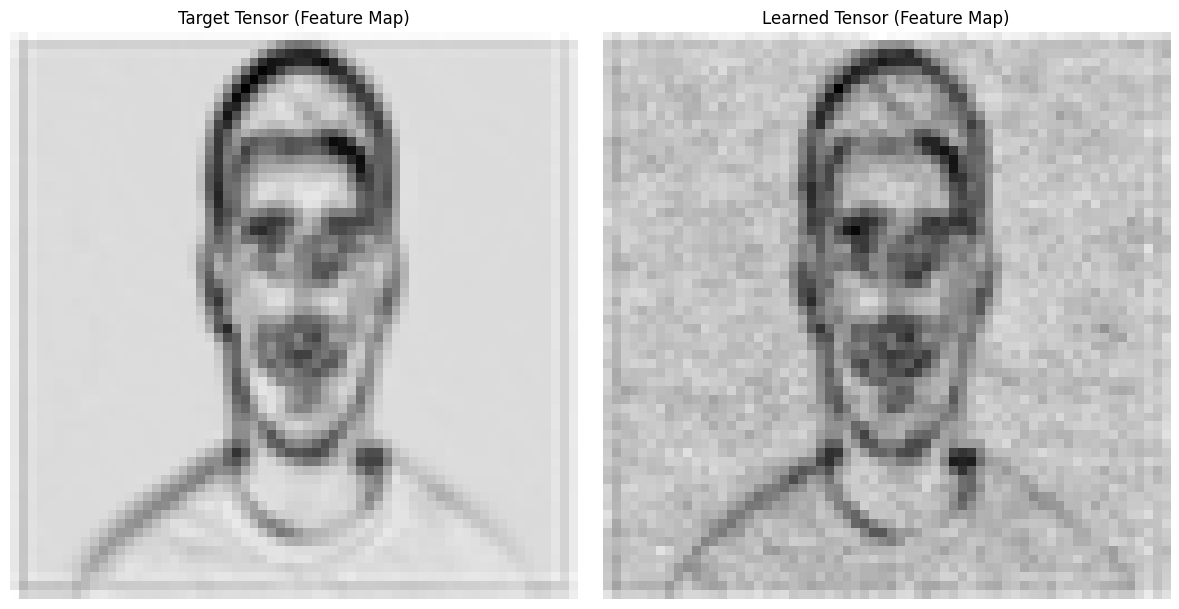

In [ ]:
import matplotlib.pyplot as plt

# 텐서를 시각화 가능하도록 numpy 배열로 변환
def tensor_to_image(tensor):
    # 텐서를 detach하고, (B, C, H, W)에서 (H, W, C)로 변환
    tensor = tensor.detach().cpu().squeeze(0)  # (C, H, W)
    tensor = tensor.mean(dim=0)  # 채널 평균 계산 (H, W)
    return tensor.numpy()

# Target 텐서와 Output 텐서를 시각화
target_image = tensor_to_image(target_tensor)
output_image = tensor_to_image(output_tensor)

# 시각화
plt.figure(figsize=(12, 6))

# Target tensor 시각화
plt.subplot(1, 2, 1)
plt.imshow(target_image, cmap='gray')
plt.title("Target Tensor (Feature Map)")
plt.axis("off")

# 학습된 require_grad_noise_tensor 시각화
plt.subplot(1, 2, 2)
plt.imshow(output_image, cmap='gray')
plt.title("Learned Tensor (Feature Map)")
plt.axis("off")

plt.tight_layout()
plt.show()

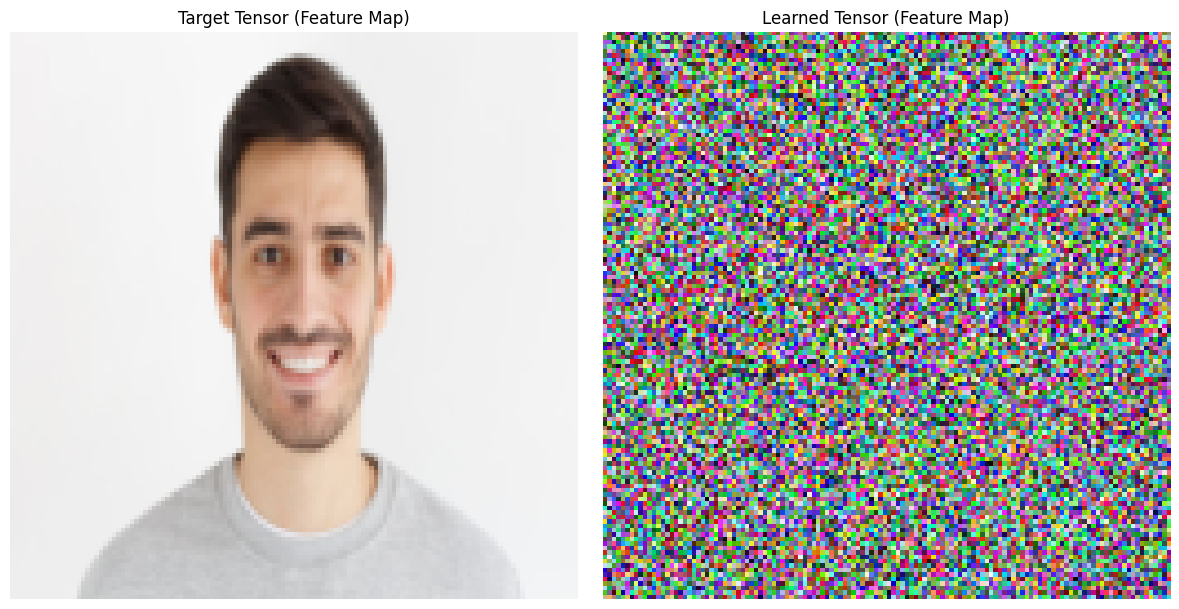

In [13]:
import torchvision.transforms as transforms

untransform = transforms.Compose([
    transforms.ToPILImage(),
])

# 시각화
plt.figure(figsize=(12, 6))

# Target tensor 시각화
plt.subplot(1, 2, 1)
plt.imshow(untransform(content_tensor.squeeze(0)), cmap='gray')
plt.title("Target Tensor (Feature Map)")
plt.axis("off")

# 학습된 require_grad_noise_tensor 시각화
plt.subplot(1, 2, 2)
plt.imshow(untransform(require_grad_noise_tensor.squeeze(0)), cmap='gray')
plt.title("Learned Tensor (Feature Map)")
plt.axis("off")

plt.tight_layout()
plt.show()
